In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class sample_random_balls(object):
    
    def __init__(self, n_centers, var_x = 1, var_y = 1, var_xy = 0, x_range = [-10, 10], y_range = [-10, 10], rotate = False):
        """
        Want to sample K blobs, with n_points per blob. Diversity range is controlled by x_range and y_range
        """
        
        self.n_centers = n_centers
        self.covariance = np.array([[var_x, var_xy], 
                                    [var_xy, var_y]])
        
        self.x_centers = np.random.random_sample(n_centers) * (x_range[1] - x_range[0]) + x_range[0]
        self.y_centers = np.random.random_sample(n_centers) * (y_range[1] - y_range[0]) + y_range[0]
        
        self.mu = np.vstack([self.x_centers, self.y_centers]).T
    
    def sample(self, n_points):
        #Find any real matrix A such that A.A^T = Cov. If Cov is positive definite, Cholesky decomposition can be used.
        #Alternatively, use spectral decomposition Cov = U.S.U^(-1) (A = U.sqrt(S)) (U is the eigenvector matrix)
        #Let z = (z_1, ..., z_n)^T be a vector whose components are N independent standard normal variables
        #let x = mu + Az.
        
        #Positive definite - x^T A x > 0 for all x (all eigenvalues are positive)
        #Positive semi-definite - x^T A x >= 0 for all x (all eigenvalues are non-negative)
        
        eig_vals, eig_vect = np.linalg.eig(self.covariance)
        
        if np.sum(eig_vals > 0) == 2:
            print("\nCovariance is positive definite.")
            
            A = np.linalg.cholesky(self.covariance)
            
        elif np.sum(eig_vals >= 0) == 2:
            print("\nCovariance is positive semi-definite.")
            
            A = np.dot(eig_vect, np.diag(np.sqrt(eig_vals)))
        
        
        point_samples = np.random.randint(low = 0, high = self.n_centers, size = n_points)
        
        z = np.random.randn(n_points, 2)
        x = self.mu[point_samples, :] + np.dot(A, z.T).T
        
        return x, point_samples

In [3]:
class k_means(object):
    def __init__(self, n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 300, tol = 1e-4, verbose = False, random_state = None, copy_x = True, algorithm = 'auto', median_flag = False, vectorise = True):
        
        self.n_clusters = n_clusters #number of clusters to initialise
        self.init = init #'k-means++' selects initial clusters intelligently. 'random' chooses n_clusters rows at random
        self.n_init = n_init #Number of time the k-means algorithm will be run with different centroid seeds.
        self.max_iter = max_iter #max iterations for a single run
        self.tol = tol #Relative tolerance with regards to Frobenius norm of the difference in the cluster centers
        #of two consecutive iterations to declare convergence.
        self.verbose = verbose #If verbose = 1, print loss over iterations
        self.random_state = random_state #Determines random number generation for centroid initialisation
        self.copy_x = copy_x #Will not modify the original data, if False, data is centered and then uncentered
        self.algorithm = algorithm #EM or elkan
        self.median_flag = median_flag
        self.vectorise = vectorise #To try and vectorise the loops
        
        if random_state is not None:
            np.random.RandomState(self.random_state)
        
        #initialised parameters
        #self.cluster_centers_ = None #coordinates of cluster centers.
        #self.labels_ = None #labels of each point
        #self.inertia_ = None #sum of squared distances of samples to their closest center, weighted by sample weights if required
        self.inertia_train_ = None #List of inertia over the optimal run
        self.n_iter_ = None #Number of iterations runs
    
    def label_data(self, X):
        N = X.shape[0]
        labels = []
        
        if self.vectorise:
            mse_mat = np.zeros((N, self.n_clusters))
            
            for k in range(self.n_clusters):
                mse_mat[:, k] = np.sum((self.cluster_centers_[k, :] - X)**2, axis = 1)
            
            labels = np.argmin(mse_mat, axis = 1)
            
        else:
            for i in range(N):
                mse = np.sum((self.cluster_centers_ - X[i, :])**2, axis = 1)
                labels.append(np.argmin(mse))
        
        return np.array(labels)
    
    def compute_centroids(self, X):
        new_centers = np.zeros((self.n_clusters, X.shape[1]))
        
        #Already vectorised to some extent
        for k in range(self.n_clusters):
            label_indices = np.nonzero(self.labels_ == k)[0]
            
            if self.median_flag:
                new_centers[k, :] = np.median(X[label_indices, :], axis = 0)
            else:
                new_centers[k, :] = np.mean(X[label_indices, :], axis = 0)
                
        tol = np.linalg.norm(self.cluster_centers_ - new_centers)
        
        self.cluster_centers_ = new_centers

        return tol
        
    def calculate_inertia(self, X):
        
        J = 0
        
        for k in range(self.n_clusters):
            label_indices = np.nonzero(self.labels_ == k)[0]
            
            if self.vectorise:
                if self.median_flag:
                    J += np.sum(np.abs(self.cluster_centers_[k, :] - X[label_indices, :]))
                    
                else:
                    J +=np.sum((self.cluster_centers_[k, :] - X[label_indices, :])**2)
            
            else:
                for i in label_indices:

                    if self.median_flag:
                        J += np.sum(np.abs(self.cluster_centers_[k, :] - X[i, :]))
                    else:
                        J += np.sum((self.cluster_centers_[k, :] - X[i, :])**2)
        
        self.inertia_ = J
    
    def initialise_centroids(self, X):
        
        if self.init == 'k-means++':
            print("Initialisation not implemented.")
            raise SystemExit
        
        elif self.init == 'random':
            
            points = np.random.randint(0, X.shape[0], self.n_clusters)
            self.cluster_centers_ = X[points, :]
        
        else:
            print("Illegal initialisation.")
            raise SystemExit
    
    def standardise(self, X):
        self._mu_ = np.mean(X, axis = 0)
        self._std_ = np.std(X, axis = 0)
        
        return (X - self._mu_) / self._std_
    
    def unstandardise(self, X):
        
        return (X * self._std_) + self._mu_
        
    def fit(self, X, sample_weights = None, calculate_scores = True):
        
        if self.verbose:
            print("Beginning K-means...")
        
        #Check to see if you must standardise
        if not self.copy_x:
            X = self.standardise(X)
        
        #Initialise iteration dictionary
        iter_dict = {}
        
        #Initialise location properties
        optimal_inertia = np.inf
        optimal_outer = None
        
        for outer_iter in range(self.n_init):
            
            #initialise centroids
            self.initialise_centroids(X)
            
            #Calculate initial inertia
            self.labels_ = self.label_data(X)
            self.calculate_inertia(X)
            
            local_inertia_list = []
            
            tol = np.inf
            cnt = 0
            
            if self.verbose:
                print("\n Beginning outer iteration {}...".format(outer_iter))
            
            while cnt < self.max_iter and tol > self.tol:
                
                #E step
                self.labels_ = self.label_data(X)
                #print(self.labels_)
                
                #M step
                tol = self.compute_centroids(X)
                
                #Calculate loss
                self.calculate_inertia(X)
                
                #Finalise iteration
                local_inertia_list.append(self.inertia_)
                cnt += 1
                
                if self.verbose:
                    print("Outer iteration {}: inertia: {}".format(outer_iter, self.inertia_))
            
            iter_dict[str(outer_iter)] = {"centers":self.cluster_centers_,
                                          "labels":self.labels_,
                                          "loss_list":local_inertia_list,
                                          "n_iters":cnt}
            
            if optimal_inertia > self.inertia_:
                optimal_inertia = self.inertia_
                optimal_outer = outer_iter
                
        if self.verbose:
            print("\n Finished Training! Automatically selecting optimal centers...")
        
        #Load in optimal clusters
        self.cluster_centers_ = iter_dict[str(optimal_outer)]["centers"]
        
        #Label data
        self.labels_ = iter_dict[str(optimal_outer)]["labels"] #Will create a disjoint if it terminates early
        
        #Store loss list
        self.inertia_train_ = iter_dict[str(optimal_outer)]["loss_list"]
        
        #Store the iteration dict
        self.iter_dict = iter_dict
        
        #Check to see if you must un-standardise
        if not self.copy_x:
            X = self.unstandardise(X)
            self.cluster_centers = self.unstandardise(self.cluster_centers)
        
        if calculate_scores:
            if self.verbose:
                print("Calculating the Silhouette score...")

            #Calculate the silhouette score
            self.silhouette_score = self.Silhouette(X, self.labels_)
        
        return self
        
    
    def predict(self, X, sample_weight = None):
        labels = self.label_data(X)
        
        return labels
    
    def fit_predict(self, X, sample_weight = None, calculate_scores = True):
        self.fit(X, sample_weight, calculate_scores)
        labels = self.predict(X)
        
        return labels
    
    def fit_transform(self, X, sample_weights = None, calculate_scores = True):
        self.fit(X, sample_weights, calculate_scores)
        X_new = self.transform(X)
        
        return X_new
    
    def score(self, X, sample_weight = None):
        
        N, _ = X.shape
            
        min_distance = np.zeros(N)
        
        if self.vectorise:
            
            d_mat = np.zeros((N, self.n_clusters))
            
            for k in self.n_clusters:
                d_mat[:, k] = np.sqrt(np.sum((self.cluster_centers_[[k], :] - X)**2, axis = 1))
            
            min_distance = np.min(d_mat, axis = 1)
        
        else:
            for i in range(N):

                d_clusters = np.sqrt(np.sum((self.cluster_centers_ - X[i, :])**2, axis = 1))

                min_distance[i] = np.min(d_clusters)
        
        return min_distance
            
    
    def Silhouette(self, X, labels):
        
        N, f = X.shape
        
        #Create label nested lists
        classes = []

        for i in range(np.max(labels) + 1): #labels are zero padded
            indices = np.argwhere(labels == i)
            
            if len(indices) != 0:
                classes.append(indices[:, 0])           
        
        #Create distance matrix
        upper_indices_row, upper_indices_col = np.triu_indices(N)
        
        d_vals = []
        d_mat = np.zeros((N, N))
        
        for i,j in zip(upper_indices_row, upper_indices_col):
            
            if i == j:
                d_vals.append(0) #Distance is zero
            
            else:
                d_vals.append(np.sum((X[i, :] - X[j, :])**2) ** 0.5)
                
        d_mat[upper_indices_row, upper_indices_col] = d_vals
        
        d_mat = d_mat + d_mat.T - np.diag(np.diag(d_mat))
        
        S = np.zeros(N)
        
        for i in range(N):
            
            label_i = labels[i]
            C_I = len(classes[label_i])
            
            d_sum = []
            
            if C_I == 1:
                S[i] = 0
            
            else:
                for j in range(np.max(labels) + 1):

                    if j == label_i:
                        Ai = np.sum(d_mat[i, classes[j]]) / (C_I - 1)

                    else:
                        d_sum.append( np.mean(d_mat[i, classes[j]]) )

                #Calculate B
                Bi = np.min(d_sum)

                S[i] = (Bi - Ai) / max(Ai, Bi)

        return np.mean(S)

    def transform(self, X): #transform X to a cluster-distance space
        print("Transform is not implemented.")
        return None
    

[[1 0]
 [0 1]]


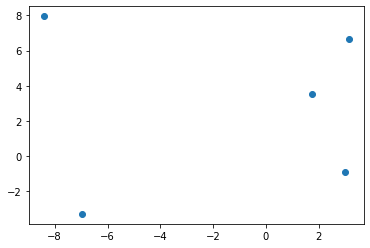


Covariance is positive definite.
(1000, 2)


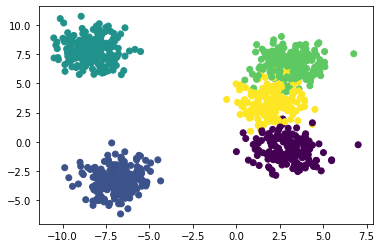

In [4]:
sample_blobs = sample_random_balls(5, var_x = 1, var_y = 1, var_xy = 0)
print(sample_blobs.covariance)
plt.figure()
plt.scatter(sample_blobs.mu[:, 0], sample_blobs.mu[:, 1])
plt.show()

x, l = sample_blobs.sample(1000)

print(x.shape)

plt.figure()
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.show()

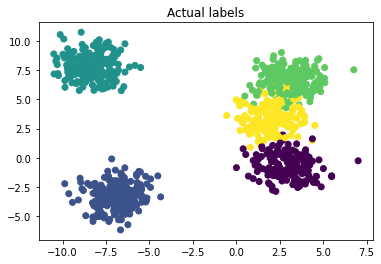

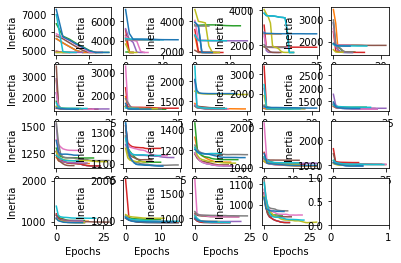

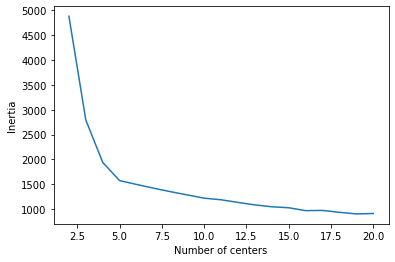

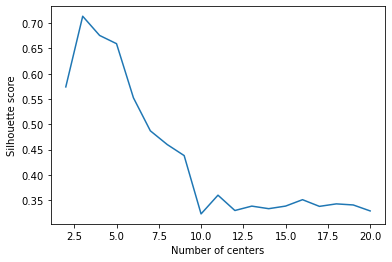

In [9]:
plt.figure()
plt.title("Actual labels")
plt.scatter(x[:, 0], x[:, 1], c = l)
#plt.scatter(k_means_local.cluster_centers_[:, 0], k_means_local.cluster_centers_[:, 1], c = "r", marker = "x")
plt.show()

L_min_list = []
S_min_list = []
center_range = range(2, 21, 1)

fig, ax = plt.subplots(4, 5)
ax = ax.flatten()

cnt = 0
for n_centers in center_range:
    L = []
    L_min = np.inf
    
    k_means_local = k_means(n_centers, 'random', max_iter = 30, median_flag = True)
    k_means_local.fit(x)
    
    L.append(k_means_local.inertia_train_)
    
    for i in k_means_local.iter_dict.keys():
        L.append(k_means_local.iter_dict[i]["loss_list"])
        
    L_min = min(L_min, k_means_local.inertia_train_[-1])
    
    L_min_list.append(L_min)
    S_min_list.append(k_means_local.silhouette_score)

    for i in range(len(L)):
        ax[cnt].plot(L[i])
    ax[cnt].set_xlabel("Epochs")
    ax[cnt].set_ylabel("Inertia")
    
    cnt += 1

plt.figure()
plt.plot(center_range, L_min_list)
plt.xlabel("Number of centers")
plt.ylabel("Inertia")
plt.show()

plt.figure()
plt.plot(center_range, S_min_list)
plt.xlabel("Number of centers")
plt.ylabel("Silhouette score")
plt.show()


[5.57403297 9.59642445]


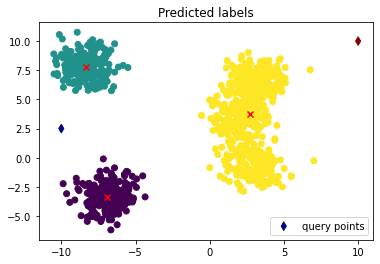

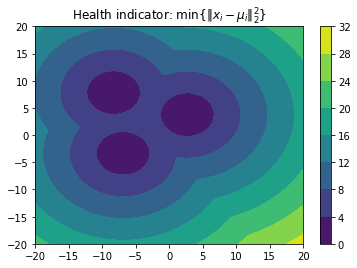

In [10]:
n_centers_optimal = center_range[np.argmax(S_min_list)]

k_means_local = k_means(n_centers_optimal, 'random', max_iter = 30, median_flag = True).fit(x)

query = np.array([[-10, 2.5], [10, 10]])
score = k_means_local.score(query)

print(score)

plt.figure()
plt.title("Predicted labels")
plt.scatter(x[:, 0], x[:, 1], c = k_means_local.labels_)
plt.scatter(k_means_local.cluster_centers_[:, 0], k_means_local.cluster_centers_[:, 1], c = "r", marker = "x")
plt.scatter(query[:, 0], query[:, 1], marker = 'd', c = score, cmap = plt.cm.jet, label = "query points")
plt.legend()
plt.show()

N_mesh = 100
X, Y = np.meshgrid(np.linspace(-20, 20, N_mesh), np.linspace(-20, 20, N_mesh))

X1 = X.reshape(-1, 1)
Y1 = Y.reshape(-1, 1)

XY = np.hstack((X1, Y1))

scores = k_means_local.score(XY)

plt.figure()
plt.title(r"Health indicator: min{$\Vert x_i - \mu_i \Vert_2^2$}")
plt.contourf(X, Y, scores.reshape(N_mesh, N_mesh))
plt.colorbar()
plt.show()